In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 
import numpy as np
import pickle
from scipy.misc import imread, imresize

from birdseye import BirdsEye
from lanefilter import LaneFilter
from curves import Curves
from helpers import show_images, save_image, roi

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
calibration_data = pickle.load(open("calibration_data.p", "rb" ))

matrix = calibration_data['camera_matrix']
distortion_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
destination_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

birdsEye = BirdsEye(source_points, destination_points, matrix, distortion_coef)
laneFilter = LaneFilter(p)
curves = Curves(number_of_windows = 9, margin = 100, minimum_pixels = 50, 
                ym_per_pix = 30 / 720 , xm_per_pix = 3.7 / 700)

In [3]:
def debug_pipeline(img):
    
  ground_img = birdsEye.undistort(img)
  birdseye_img = birdsEye.sky_view(img)
    
  binary_img = laneFilter.apply(ground_img)
  sobel_img = birdsEye.sky_view(laneFilter.sobel_breakdown(ground_img))
  color_img = birdsEye.sky_view(laneFilter.color_breakdown(ground_img))
  
  wb = np.logical_and(birdsEye.sky_view(binary_img), roi(binary_img)).astype(np.uint8)
  result = curves.fit(wb)
    
  left_curve =  result['pixel_left_best_fit_curve']
  right_curve =  result['pixel_right_best_fit_curve']
    
  left_radius =  result['left_radius']
  right_radius =  result['right_radius']
  pos = result['vehicle_position_words']
  curve_debug_img = result['image']
  
  projected_img = birdsEye.project(ground_img, binary_img, left_curve, right_curve)
    
  return birdseye_img, sobel_img, color_img, curve_debug_img, projected_img, left_radius, right_radius, pos 

In [4]:
def verbose_pipeline(img):
  b_img, s_img, co_img, cu_img, pro_img, lr, rr, pos = debug_pipeline(img)

  b_img = imresize(b_img, 0.25)
  s_img = imresize(s_img, 0.25)
  co_img = imresize(co_img, 0.25)
  cu_img = imresize(cu_img, 0.25)

  offset = [0, 320, 640, 960]
  width, height = 320,180

  pro_img[:height, offset[0]: offset[0] + width] = b_img
  pro_img[:height, offset[1]: offset[1] + width] = co_img
  pro_img[:height, offset[2]: offset[2] + width] = s_img
  pro_img[:height, offset[3]: offset[3] + width] = cu_img

  text_pos = "vehicle pos: " + pos
  text_l = "left r: " + str(np.round(lr, 2)) 
  text_r = " right r: " + str(np.round(rr, 2))
    
  cv2.putText(pro_img, text_l, (20, 220), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
  cv2.putText(pro_img, text_r, (250, 220), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
  cv2.putText(pro_img, text_pos, (620, 220), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)

  return pro_img 


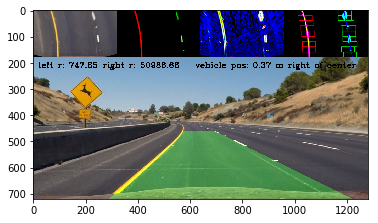

In [5]:
path = "test_images/test2.jpg"
img = imread(path)
plt.imshow(verbose_pipeline(img))

In [6]:
project_output = 'project_video_verbose_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(verbose_pipeline) 
%time white_clip.write_videofile(project_output, audio = False);

[MoviePy] >>>> Building video project_video_verbose_output.mp4
[MoviePy] Writing video project_video_verbose_output.mp4


100%|█████████▉| 1260/1261 [17:01<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_verbose_output.mp4 

CPU times: user 15min 25s, sys: 3min, total: 18min 25s
Wall time: 17min 3s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))